## Notebook to fit triple orbits with astrometry + rv

In [1]:
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm import tqdm
import matplotlib.cm as cm
from read_data import read_data,read_rv,read_wds,read_orb6
from astrometry_model import astrometry_model,astrometry_model_vlti,rv_model,rv_model_circular,triple_model,triple_model_circular,triple_model_combined,triple_model_combined2,triple_model_vlti_combined,triple_model_vlti,triple_model_combined_circular,lnlike,lnprior,lnpost,create_init
from orbit_plotting import orbit_model,triple_orbit_model
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import random
from PyAstronomy.pyasl import foldAt
from PyAstronomy import pyasl
from uncertainties import ufloat,umath
from uncertainties.umath import *
import emcee
import corner
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
ks=pyasl.MarkleyKESolver()

%matplotlib inline

In [2]:
## setup paths for user
path = '/Users/tgardne/ARMADA_orbits'
path_etalon = '/Users/tgardne/etalon_epochs/etalon_fits/etalon_factors_fit.txt'
path_wds = '/Users/tgardne/ARMADA_orbits'
path_orb6 = '/Users/tgardne/catalogs/orb6orbits.sql.txt'

In [3]:
## Specify target
target_hd = '6456' ## HD number
note = 'rv' ## note for saved file
corrected = 'n' ## bootstrap errors?

scale = 1

In [4]:
query = Simbad.query_objectids('HD %s'%target_hd)
for item in query:
    if 'HIP' in item[0]:
        target = item[0].split()[1]
        print('HIP %s'%target)
    if 'WDS' in item[0]:
        target_wds = item[0][5:15]
        print('WDS %s'%target_wds)

HIP 5131
WDS 01057+2128
WDS 01057+2128


In [5]:
#target_wds = '09320-0111'

In [6]:
###########################################
## Read in ARMADA data
###########################################
if corrected == 'y':
    print('reading boostrap errors')
    file=open('%s/HD_%s_bootstrap.txt'%(path,target_hd))
else:
    print('reading chi2 errors')
    file=open('%s/HD_%s_chi2err.txt'%(path,target_hd))
weight=1

t,p,theta,error_maj,error_min,error_pa,error_deg = read_data(file,weight)
file.close()

p /= scale

file_rv=open('%s/HD_%s_rv.txt'%(path,target_hd))

weight_rv = 1.0 ## km/s error

t_rv,rv,err_rv = read_rv(file_rv,weight_rv)
file_rv.close()

reading chi2 errors


FileNotFoundError: [Errno 2] No such file or directory: '/Users/tgardne/ARMADA_orbits/HD_6456_rv.txt'

In [7]:
## print rv for paper
for i,j,k in zip(t_rv,rv,err_rv):
    print('& %s & %s & %s \\\\'%(i,j,k))

NameError: name 't_rv' is not defined

In [8]:
### correct PAs based on precession
coord = SkyCoord.from_name("HD %s"%target_hd,parse=True)
ra = coord.ra.value*np.pi/180
dec = coord.dec.value*np.pi/180
#theta -= (0.00557*np.sin(ra)/np.cos(dec)*((t-51544.5)/365.25))/180*np.pi

In [9]:
###########################################
## Apply etalon correction
###########################################
file=open(path_etalon)
mjd_etalon=[]
f_etalon=[]
for line in file.readlines():
    if line.startswith('#'):
        continue
    mjd_etalon.append(float(line.split()[0]))
    f_etalon.append(float(line.split()[1]))
file.close()
mjd_etalon=np.array(mjd_etalon)
f_etalon=np.array(f_etalon)

etalon_factor=[]
for i in t:
    idx = np.where(abs(i-mjd_etalon)==min(abs(i-mjd_etalon)))
    if min(abs(i-mjd_etalon))>0.5:
        print('Closest factor for %s is %s days away'%(i,min(abs(i-mjd_etalon))))
    f = f_etalon[idx][0]
    etalon_factor.append(f)
etalon_factor=np.array(etalon_factor)

print('   date      etalon factor')
for i,j in zip(t,etalon_factor):
    print(i,j)

   date      etalon factor
58380.3603 1.0000200364737395
58443.2198 0.9988046915708745
58695.4592 1.000721792205869
58701.4373 1.0006698603694664
58703.4547 1.0007788200839338
58734.3688 1.0008714382436927
58770.3171 1.0008500320628442
58799.2639 1.0006529677953382
59043.4865 1.0002314553554172
59076.464 1.0001222049414369
59152.2487 1.000170490529272
59153.2767 1.0000797280528204
59158.2505 1.0000771764439695
59376.5003 1.0003033875527025
59409.5055 1.000265841816449
59410.4776 1.0001304544024734
59433.5203 1.0001301138354115
59434.5208 1.0001821901021246
59435.5076 1.0001880476654907
59482.4128 1.000095456341493
59483.3485 1.0001294189576677
59538.236 1.0002008285205146
59553.1776 1.000197511398599


In [10]:
## set etalon factors to 1 for vlti data
vlti = 'n'
if vlti=='y':
    vlti_idx = input('enter indices (e.g. 1 2 3): ').split(' ')
    vlti_idx = np.array([int(i) for i in vlti_idx])
else:
    vlti_idx = []
    
## Apply etalon
etalon = 'y'
if etalon=='y':
    print('Applying etalon correction')
    if len(vlti_idx)>0:
        print('Setting VLTI correction factors to 1.0')
        etalon_factor[vlti_idx] = 1.0
    p = p/etalon_factor
else:
    print('No etalon correction applied')

Applying etalon correction


In [11]:
xpos=p*np.sin(theta)
ypos=p*np.cos(theta)

vlti_mask = np.ones(len(t),dtype=bool)
vlti_mask[vlti_idx] = False

Number of WDS data points = 17


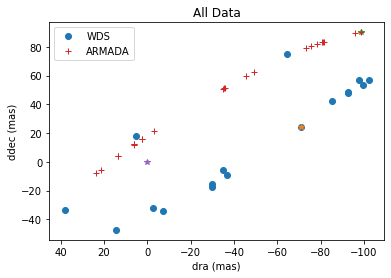

Flip WDS data? (y/n):  n


In [12]:
###########################################
## Read in WDS data - and plot to check
###########################################
input_wds = 'y'
if input_wds == 'y':
    file=open(os.path.expanduser("%s/HD%s_chi2err/HD_%s_wds.txt"%(path_wds,target_hd,target_hd)))
    weight = 1
    t_wds,p_wds,theta_wds,error_maj_wds,error_min_wds,error_pa_wds,error_deg_wds = read_data(file,weight)
    print('Number of WDS data points = %s'%len(p_wds))

    ## correct WDS for PA
    #theta_wds -= (0.00557*np.sin(ra)/np.cos(dec)*((t_wds-51544.5)/365.25))/180*np.pi

    xpos_wds=p_wds*np.sin(theta_wds)
    ypos_wds=p_wds*np.cos(theta_wds)
    idx = np.argmin(t)

    plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
    plt.plot(xpos_wds[0],ypos_wds[0],'*')
    plt.plot(xpos[idx],ypos[idx],'*')
    if len(vlti_idx)>0:
        plt.plot(xpos[vlti_mask],ypos[vlti_mask],'+',label='ARMADA-CHARA')
        plt.plot(xpos[vlti_idx],ypos[vlti_idx],'+',label='ARMADA-VLTI')
    else:
        plt.plot(xpos,ypos,'+',label='ARMADA')
    plt.plot(0,0,'*')
    plt.gca().invert_xaxis()
    plt.title('All Data')
    plt.xlabel('dra (mas)')
    plt.ylabel('ddec (mas)')
    plt.legend()
    plt.show()

    flip = input('Flip WDS data? (y/n): ')
    if flip=='y':
        xpos_wds=-p_wds*np.sin(theta_wds)
        ypos_wds=-p_wds*np.cos(theta_wds)
        plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
        plt.plot(xpos_wds[0],ypos_wds[0],'*')
        plt.plot(xpos[idx],ypos[idx],'*')
        plt.plot(xpos,ypos,'+',label='ARMADA')
        plt.plot(0,0,'*')
        plt.gca().invert_xaxis()
        plt.title('All Data')
        plt.xlabel('dra (mas)')
        plt.ylabel('ddec (mas)')
        plt.legend()
        plt.show()

        better = input('Flip data back to original? (y/n): ')
        if better=='y':
            xpos_wds=p_wds*np.sin(theta_wds)
            ypos_wds=p_wds*np.cos(theta_wds)
else:
    t_wds = np.array([np.nan])
    p_wds = np.array([np.nan])
    theta_wds = np.array([np.nan])
    error_maj_wds = np.array([np.nan])
    error_min_wds = np.array([np.nan])
    error_pa_wds = np.array([np.nan])
    error_deg_wds = np.array([np.nan])
    xpos_wds=p_wds*np.sin(theta_wds)
    ypos_wds=p_wds*np.cos(theta_wds)
    print('NO WDS DATA')

In [13]:
###########################################
## Get an estimate of the orbital parameters
###########################################
try:
    a,P,e,inc,omega,bigomega,T = read_orb6(target,path_orb6)
except:
    print('No elements found in ORB6')
    
self_params = 'n'
if self_params=='y':
    a = float(input('a (mas): '))
    P = float(input('P (year): '))*365.25
    e = float(input('ecc : '))
    inc = float(input('inc (deg): '))
    omega = float(input('omega (deg): '))
    bigomega = float(input('bigomega (deg): '))
    T = float(input('T (mjd): '))
    

found target!
--------------------------
a(mas),P(yr),e,i(deg),omega(deg),bigomega(deg),T(mjd)
114.3 14.439999999999998 0.519 77.43 305.4 134.8 54287.7294064
--------------------------


In [14]:
###########################################
## Combined WDS+ARMADA for fitting
###########################################
xpos_all = np.concatenate([xpos,xpos_wds])
ypos_all = np.concatenate([ypos,ypos_wds])
t_all = np.concatenate([t,t_wds])
error_maj_all = np.concatenate([error_maj,error_maj_wds])
error_min_all = np.concatenate([error_min,error_min_wds])
error_pa_all = np.concatenate([error_pa,error_pa_wds])
error_deg_all = np.concatenate([error_deg,error_deg_wds])

vlti_mask_all = np.ones(len(t_all),dtype=bool)
vlti_mask_all[vlti_idx] = False

In [15]:
##########################################
## Function for fitting/plotting data
#########################################
def ls_fit(params,xp,yp,tp,emaj,emin,epa):
    #do fit, minimizer uses LM for least square fitting of model to data
    if len(vlti_idx)>0:
        minner = Minimizer(astrometry_model_vlti, params, fcn_args=(xp[vlti_mask_all],yp[vlti_mask_all],tp[vlti_mask_all],
                                                        emaj[vlti_mask_all],emin[vlti_mask_all],epa[vlti_mask_all],
                                                        xp[vlti_idx],yp[vlti_idx],tp[vlti_idx],
                                                        emaj[vlti_idx],emin[vlti_idx],epa[vlti_idx]),
                                nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(astrometry_model, params, fcn_args=(xp,yp,tp,
                                                        emaj,emin,epa),
                                nan_policy='omit')
        result = minner.minimize()

    # write error report
    print(report_fit(result))

    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                 error_min,error_pa)
    resids_wds = astrometry_model(result.params,xpos_wds,ypos_wds,t_wds,error_maj_wds,
                                 error_min_wds,error_pa_wds)
    ndata_armada = 2*sum(~np.isnan(xpos))
    ndata_wds = 2*sum(~np.isnan(xpos_wds))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
    chi2_wds = np.nansum(resids_wds**2)/(ndata_wds-7)
    print('-'*10)
    print('chi2 armada = %s'%chi2_armada)
    print('-'*10)
    print('chi2 wds = %s'%chi2_wds)
    print('-'*10)

    ## plot fit
    scale=1
    if chi2_armada<1.0 and chi2_armada>0:
        scale=1/np.sqrt(chi2_armada)
    a_start = result.params['a']
    P_start = result.params['P']
    e_start = result.params['e']
    inc_start = result.params['inc']
    w_start = result.params['w']
    bigw_start = result.params['bigw']
    T_start = result.params['T']
    mirc_scale_start = result.params['mirc_scale']

    ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                            w_start,bigw_start,P_start,
                                            T_start,t_all)
    fig,ax=plt.subplots()
    ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
    if len(vlti_idx)>0:
        ax.plot(xpos[vlti_idx]*mirc_scale_start,ypos[vlti_idx]*mirc_scale_start,'o', label='ARMADA-VLTI')
        ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
    else:
        ax.plot(xpos,ypos,'o', label='ARMADA')
    ax.plot(0,0,'*')
    ax.plot(ra, dec, '--',color='g')
    #plot lines from data to best fit orbit
    i=0
    while i<len(decpoints):
        x=[xpos_all[i],rapoints[i]]
        y=[ypos_all[i],decpoints[i]]
        ax.plot(x,y,color="black")
        i+=1
    ax.set_xlabel('milli-arcsec')
    ax.set_ylabel('milli-arcsec')
    ax.invert_xaxis()
    ax.axis('equal')
    ax.set_title('HD%s Outer Orbit'%target_hd)
    plt.legend()
    plt.show()

    return result

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 80
    # variables        = 7
    chi-square         = 64.7776679
    reduced chi-square = 0.88736531
    Akaike info crit   = -2.88525778
    Bayesian info crit = 13.7889287
[[Variables]]
    w:           305.110786 +/- 0.16989729 (0.06%) (init = 305.4)
    bigw:        135.055717 +/- 0.00857891 (0.01%) (init = 134.8)
    inc:         77.5880170 +/- 0.02577559 (0.03%) (init = 77.43)
    e:           0.52010358 +/- 9.6026e-04 (0.18%) (init = 0.519)
    a:           115.553119 +/- 0.12221288 (0.11%) (init = 114.3)
    P:           5308.71187 +/- 6.53036008 (0.12%) (init = 5270.6)
    T:           54289.8916 +/- 6.80983672 (0.01%) (init = 54287.73)
    mirc_scale:  1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(P, T)      = -1.000
    C(w, a)      = -0.961
    C(inc, e)    = -0.954
    C(a, T)      = -0.871
    C(a, P)      =  0.868
    C(w, inc)    = -0.864
  

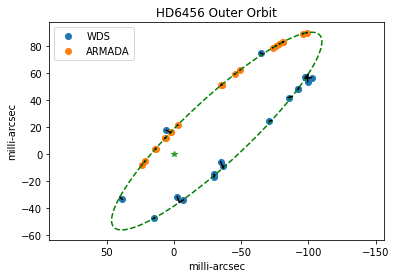

In [18]:
###########################################
## Do a least-squares fit
###########################################
params = Parameters()
params.add('w',   value= omega, min=0, max=380)
params.add('bigw', value= bigomega, min=0, max=360)
params.add('inc', value= inc, min=0, max=180)
params.add('e', value= e, min=0, max=0.99)
params.add('a', value= a, min=0)
params.add('P', value= P, min=0)
params.add('T', value= T, min=0)
if len(vlti_idx)>0:
    params.add('mirc_scale', value=1)
else:
    params.add('mirc_scale',value=1,vary=False)

result = ls_fit(params,xpos_all,ypos_all,t_all,error_maj_all,error_min_all,error_pa_all)

In [17]:
## scale errors to fit again
chara_scale = 1/np.sqrt(0.24)
vlti_scale = 1
wds_scale = 1/np.sqrt(1)

if len(vlti_idx)>0:
    error_maj[vlti_idx]/=vlti_scale
    error_min[vlti_idx]/=vlti_scale
    error_maj_all[vlti_idx]/=vlti_scale
    error_min_all[vlti_idx]/=vlti_scale
    
    error_maj[vlti_mask]/=chara_scale
    error_min[vlti_mask]/=chara_scale
    error_maj_all[vlti_mask_all]/=chara_scale
    error_min_all[vlti_mask_all]/=chara_scale
    
    error_maj_wds/=wds_scale
    error_min_wds/=wds_scale
    error_maj_all[len(xpos):]/=wds_scale
    error_min_all[len(xpos):]/=wds_scale
    
else:
    error_maj/=chara_scale
    error_min/=chara_scale
    error_maj_all[:len(error_maj)]/=chara_scale
    error_min_all[:len(error_maj)]/=chara_scale
    
    error_maj_wds/=wds_scale
    error_min_wds/=wds_scale
    error_maj_all[len(xpos):]/=wds_scale
    error_min_all[len(xpos):]/=wds_scale

----------
chi2 armada = 0.9942832736800122
----------


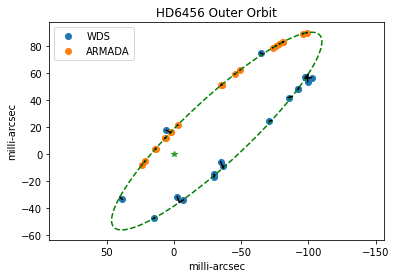

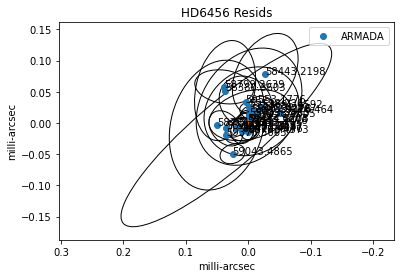

----------
Mean residual = 22.8 micro-as
----------


In [19]:
##########################################
## Save Plots
##########################################
if len(vlti_idx)>0:
    resids_armada = astrometry_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
else:
    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))
chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

if corrected == 'y':
    directory='%s/HD%s_bootstrap_triple/'%(path,target_hd)
else:
    directory='%s/HD%s_chi2err_triple/'%(path,target_hd)
if not os.path.exists(directory):
    os.makedirs(directory)

## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
a_start = result.params['a']
P_start = result.params['P']
e_start = result.params['e']
inc_start = result.params['inc']
w_start = result.params['w']
bigw_start = result.params['bigw']
T_start = result.params['T']
mirc_scale_start = result.params['mirc_scale']
ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                        w_start,bigw_start,P_start,
                                        T_start,t_all)
fig,ax=plt.subplots()
ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx]*mirc_scale_start,ypos[vlti_idx]*mirc_scale_start,'o', label='ARMADA-VLTI')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xpos,ypos,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')
#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_outer_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## plot resids for ARMADA
fig,ax=plt.subplots()
if len(vlti_idx)>0:
    xresid_vlti = xpos[vlti_idx]*mirc_scale_start - rapoints[:len(xpos)][vlti_idx]
    yresid_vlti = ypos[vlti_idx]*mirc_scale_start - decpoints[:len(ypos)][vlti_idx]
    xresid_chara = xpos[vlti_mask] - rapoints[:len(xpos)][vlti_mask]
    yresid_chara = ypos[vlti_mask] - decpoints[:len(ypos)][vlti_mask]
    xresid = np.concatenate([xresid_chara,xresid_vlti])
    yresid = np.concatenate([yresid_chara,yresid_vlti])
else:
    xresid = xpos - rapoints[:len(xpos)]
    yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle,d in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg,t):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.annotate(d,xy=(ras,decs))
    ax.add_patch(ellipse)

if len(vlti_idx)>0:
    ax.plot(xresid[vlti_idx],yresid[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xresid[vlti_mask],yresid[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xresid,yresid,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_resid_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

## Save txt file with best orbit
f = open("%s/%s_%s_orbit_binary.txt"%(directory,target_hd,note),"w+")
f.write("# P(d) a(mas) e i(deg) w(deg) W(deg) T(mjd) mirc_scale mean_resid(mu-as)\r\n")
f.write("%s %s %s %s %s %s %s %s %s"%(P_start.value,a_start.value,e_start.value,
                                   inc_start.value*180/np.pi,w_start.value*180/np.pi,
                                   bigw_start.value*180/np.pi,T_start.value,
                                  mirc_scale_start.value,resids_median))
f.close()

In [20]:
##########################################
## User input for additional companions
##########################################
P2 = 13.1
a2 = 0.04
inc2 = 100
circular = 'y'

include_rv = 'n'

In [33]:
P2_best = []
a2_best = []
e2_best = []
w2_best = []
bigw2_best = []
inc2_best = []
T2_best = []
P_best = []
a_best = []
e_best = []
w_best = []
bigw_best = []
inc_best = []
T_best = []
mirc_scale_best = []
chi2_results = []

K_best = []
#K_outer_best = []
gamma_best = []

for i in tqdm(np.arange(50)):
    bigw2 = random.uniform(0,180) ## LOOOOK HERE
    T2 = random.uniform(np.median(t),np.max(t))
    if include_rv=='y':
        K = random.uniform(-50,50)
        K_outer = random.uniform(-50,50)
        gamma = random.uniform(-30,30)
    if circular!='y':
        e2 = random.uniform(0,0.99)
        w2 = random.uniform(0,360)
    if inc2=='n':
        inc2_guess = random.uniform(0,180)

    params = Parameters()
    if circular=='y':
        params.add('e2',value=0,vary=False)
        params.add('w2',value=0,vary=False)
    else:
        params.add('e2',value=e2,min=0,max=0.99)
        params.add('w2',value=w2,min=0,max=360)
    params.add('w',   value= w_start, min=0, max=380)
    params.add('bigw', value= bigw_start, min=0, max=360)
    params.add('inc', value= inc_start, min=0, max=180)
    params.add('e', value= e_start, min=0, max=0.99)
    params.add('a', value= a_start, min=0)
    params.add('P', value= P_start, min=0)
    params.add('T', value= T_start, min=0)
    params.add('bigw2', value= bigw2, min=0, max=360) ## LOOOOK HERE
    if inc2=='n':
        params.add('inc2', value= inc2_guess, min=0, max=180)
    else:
        params.add('inc2', value= inc2, min=0, max=180)
    params.add('a2', value= a2, min=0)
    params.add('P2', value= P2, min=0)
    params.add('T2', value= T2, min=0)
    if include_rv=='y':
        params.add('K',value=K)
        #params.add('K_outer',value=K_outer)
        params.add('gamma',value=gamma)
    if len(vlti_idx)>0:
        params.add('mirc_scale', value=1)
    else:
        params.add('mirc_scale',value=1,vary=False)

    #do fit, minimizer uses LM for least square fitting of model to data
    if include_rv=='y':
        if len(vlti_idx)>0:
            minner = Minimizer(triple_model_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                                error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                                error_pa_all[vlti_mask_all],
                                                                xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                                error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                                error_pa_all[vlti_idx],rv,t_rv,err_rv),
                                nan_policy='omit')
            result = minner.minimize()
        else:
            minner = Minimizer(triple_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                                error_maj_all,error_min_all,
                                                                error_pa_all,rv,t_rv,err_rv),
                                nan_policy='omit')
            result = minner.minimize()
        #try:
        #    print(report_fit(result))
        #except:
        #    print('No fit report')
        
    else:
        if len(vlti_idx)>0:
            minner = Minimizer(triple_model_vlti, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                                error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                                error_pa_all[vlti_mask_all],
                                                                xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                                error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                                error_pa_all[vlti_idx]),
                                nan_policy='omit')
            result = minner.minimize()
        else:
            minner = Minimizer(triple_model, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                                error_maj_all,error_min_all,
                                                                error_pa_all),
                                nan_policy='omit')
            result = minner.minimize()
        #try:
        #    print(report_fit(result))
        #except:
        #    print('No fit report')

    P2_best.append(result.params['P2'])
    a2_best.append(result.params['a2'])
    e2_best.append(result.params['e2'])
    w2_best.append(result.params['w2'])
    bigw2_best.append(result.params['bigw2'])
    inc2_best.append(result.params['inc2'])
    T2_best.append(result.params['T2'])
    P_best.append(result.params['P'])
    a_best.append(result.params['a'])
    e_best.append(result.params['e'])
    w_best.append(result.params['w'])
    bigw_best.append(result.params['bigw'])
    inc_best.append(result.params['inc'])
    T_best.append(result.params['T'])
    if include_rv=='y':
        K_best.append(result.params['K'])
        #K_outer_best.append(result.params['K_outer'])
        gamma_best.append(result.params['gamma'])
    mirc_scale_best.append(result.params['mirc_scale'])
    chi2_results.append(result.redchi)

100%|██████████| 50/50 [00:35<00:00,  1.41it/s]


In [34]:
P2_best = np.array(P2_best)
a2_best = np.array(a2_best)
e2_best = np.array(e2_best)
w2_best = np.array(w2_best)
bigw2_best = np.array(bigw2_best)
inc2_best = np.array(inc2_best)
T2_best = np.array(T2_best)
P_best = np.array(P_best)
a_best = np.array(a_best)
e_best = np.array(e_best)
w_best = np.array(w_best)
bigw_best = np.array(bigw_best)
inc_best = np.array(inc_best)
T_best = np.array(T_best)
if include_rv=='y':
    K_best = np.array(K_best)
#    K_outer_best = np.array(K_outer_best)
    gamma_best = np.array(gamma_best)
mirc_scale_best = np.array(mirc_scale_best)
chi2_results = np.array(chi2_results)

idx = np.argmin(chi2_results)
P2_best = P2_best[idx]
a2_best = a2_best[idx]
e2_best = e2_best[idx]
w2_best = w2_best[idx]
bigw2_best = bigw2_best[idx]
inc2_best = inc2_best[idx]
T2_best = T2_best[idx]
P_best = P_best[idx]
a_best = a_best[idx]
e_best = e_best[idx]
w_best = w_best[idx]
bigw_best = bigw_best[idx]
inc_best = inc_best[idx]
T_best = T_best[idx]
if include_rv=='y':
    K_best = K_best[idx]
    #K_outer_best = K_outer_best[idx]
    gamma_best = gamma_best[idx]
mirc_scale_best = mirc_scale_best[idx]

In [52]:
include_rv = 'n'
circular = 'n'

P2_best = 6.9*365.25
a2_best = 10
e2_best = 0.5
w2_best = 298
bigw2_best = 143
inc2_best = 111
T2_best = 59528

P_best = 21*365.25
a_best = 90
e_best = 0.07
w_best = 3
bigw_best = 19
inc_best = 136
T_best = 57922
if include_rv=='y':
    K_best = 3.4
    #K_outer_best = K_outer_best[idx]
    gamma_best = 24
mirc_scale_best = 1.0

In [35]:
## Save a fit for errors
params = Parameters()
params.add('w',   value = w_best, min=0, max=380)
params.add('bigw', value = bigw_best, min=0, max=360)
params.add('inc', value = inc_best, min=0, max=180)
params.add('e', value = e_best, min=0, max=0.99)
params.add('a', value = a_best, min=0)
params.add('P', value = P_best, min=0)
params.add('T', value = T_best, min=0)

if circular!='y':
    params.add('w2',   value= w2_best, min=0, max=360)
    params.add('e2', value= e2_best, min=0,max=0.99)
else:
    params.add('w2',   value= 0, vary=False)
    params.add('e2', value= 0, vary=False)
        
params.add('bigw2', value= bigw2_best, min=0, max=360)
params.add('inc2', value= inc2_best, min=0, max=180)
params.add('a2', value= a2_best, min=0)
params.add('P2', value= P2_best, min=0)
params.add('T2', value= T2_best, min=0)

if include_rv=='y':
    params.add('K', value= K_best)
    #params.add('K_outer', value= K_outer_best)
    params.add('gamma', value= gamma_best)

if len(vlti_idx)>0:
    params.add('mirc_scale', value=mirc_scale_best)
else:
    params.add('mirc_scale',value=1,vary=False)

#params.add('pscale', value=1)

#do fit, minimizer uses LM for least square fitting of model to data
if include_rv=='y':
    if len(vlti_idx)>0:
        minner = Minimizer(triple_model_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                            error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                            error_pa_all[vlti_mask_all],
                                                            xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                            error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                            error_pa_all[vlti_idx],rv,t_rv,err_rv),
                            nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(triple_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                            error_maj_all,error_min_all,
                                                            error_pa_all,rv,t_rv,err_rv),
                            nan_policy='omit')
        result = minner.minimize()
    include_rv = 'y'
else:
    if len(vlti_idx)>0:
        minner = Minimizer(triple_model_vlti, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                            error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                            error_pa_all[vlti_mask_all],
                                                            xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                            error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                            error_pa_all[vlti_idx]),
                            nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(triple_model, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                            error_maj_all,error_min_all,
                                                            error_pa_all),
                            nan_policy='omit')
        result = minner.minimize()

report_fit(result)
    
P2_best = result.params['P2'].value
a2_best = result.params['a2'].value
e2_best = result.params['e2'].value
w2_best = result.params['w2'].value
bigw2_best = result.params['bigw2'].value
inc2_best = result.params['inc2'].value
T2_best = result.params['T2'].value
P_best = result.params['P'].value
a_best = result.params['a'].value
e_best = result.params['e'].value
w_best = result.params['w'].value
bigw_best = result.params['bigw'].value
inc_best = result.params['inc'].value
T_best = result.params['T'].value
if include_rv=='y':
    K_best = result.params['K'].value
    #K_outer_best = result.params['K_outer'].value
    gamma_best = result.params['gamma'].value
mirc_scale_best = result.params['mirc_scale'].value

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14
    # data points      = 80
    # variables        = 12
    chi-square         = 59.9949924
    reduced chi-square = 0.88227930
    Akaike info crit   = 0.97875717
    Bayesian info crit = 29.5630768
[[Variables]]
    w:           305.133968 +/- 0.14053772 (0.05%) (init = 305.134)
    bigw:        135.043057 +/- 0.00710758 (0.01%) (init = 135.0431)
    inc:         77.6022254 +/- 0.01936156 (0.02%) (init = 77.60223)
    e:           0.51952074 +/- 7.3735e-04 (0.14%) (init = 0.5195207)
    a:           115.571790 +/- 0.10725693 (0.09%) (init = 115.5718)
    P:           5308.77650 +/- 6.36671522 (0.12%) (init = 5308.777)
    T:           54290.3269 +/- 6.63614378 (0.01%) (init = 54290.33)
    w2:          0 (fixed)
    e2:          0 (fixed)
    bigw2:       129.308566 +/- 7.68950395 (5.95%) (init = 129.3098)
    inc2:        102.888657 +/- 7.49833322 (7.29%) (init = 102.8885)
    a2:          0.03935140 +/-

In [36]:
##########################################
## Save Plots for Triple
##########################################
if len(vlti_idx)>0:
    resids_armada = triple_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
    
    resids_vlti = triple_model_vlti(result.params,np.array([np.nan]),np.array([np.nan]),np.array([np.nan]),
                                    np.array([np.nan]),np.array([np.nan]),np.array([np.nan]),
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
    
    resids_chara = triple_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                np.array([np.nan]),np.array([np.nan]),np.array([np.nan]),
                                    np.array([np.nan]),np.array([np.nan]),np.array([np.nan]))
    
else:
    resids_armada = triple_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
    
ndata_armada = 2*sum(~np.isnan(xpos))

if circular=='y':
    print(ndata_armada)
    print(len(result.params))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-12)
else:
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-14)

print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

if len(vlti_idx)>0:
    ndata_vlti = 2*sum(~np.isnan(xpos[vlti_idx]))
    ndata_chara = 2*sum(~np.isnan(xpos)) - 2*sum(~np.isnan(xpos[vlti_idx]))
    print(ndata_vlti)
    print(ndata_chara)
    if circular=='y':
        chi2_vlti = np.nansum(resids_vlti**2)/(ndata_vlti-12)
        chi2_chara = np.nansum(resids_chara**2)/(ndata_chara-12)
    else:
        chi2_vlti = np.nansum(resids_vlti**2)/(ndata_vlti-14)
        chi2_chara = np.nansum(resids_chara**2)/(ndata_chara-14)
        
    print('-'*10)
    print('chi2 chara = %s'%chi2_chara)
    print('-'*10)
    print('chi2 vlti = %s'%chi2_vlti)
    print('-'*10)

46
15
----------
chi2 armada = 0.9957672090294529
----------


In [25]:
## scale errors to fit again

armada_scale = 1/np.sqrt(0.46)
vlti_scale = 1/np.sqrt(1)
chara_scale = 1/np.sqrt(1)

if len(vlti_idx)>0:
    error_maj[vlti_idx]/=vlti_scale
    error_min[vlti_idx]/=vlti_scale
    error_maj_all[vlti_idx]/=vlti_scale
    error_min_all[vlti_idx]/=vlti_scale
    
    error_maj[vlti_mask]/=chara_scale
    error_min[vlti_mask]/=chara_scale
    error_maj_all[vlti_mask_all]/=chara_scale
    error_min_all[vlti_mask_all]/=chara_scale
    
else:
    error_maj/=armada_scale
    error_min/=armada_scale
    error_maj_all[:len(error_maj)]/=armada_scale
    error_min_all[:len(error_maj)]/=armada_scale

In [37]:
if len(vlti_idx)>0:
    xpos[vlti_mask]/=mirc_scale_best
    ypos[vlti_mask]/=mirc_scale_best
    xpos_all[vlti_mask_all]/=mirc_scale_best
    ypos_all[vlti_mask_all]/=mirc_scale_best
else:
    idx = np.where(t<58757)
    xpos[idx]/=mirc_scale_best
    ypos[idx]/=mirc_scale_best
    idx = np.where(t_all<58757)
    xpos_all[idx]/=mirc_scale_best
    ypos_all[idx]/=mirc_scale_best

In [38]:
## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
    print(scale)
else:
    scale=float(input('scale errors by: '))

tmod = np.linspace(min(t_all),min(t_all)+2*P_best,1000)
ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,t_all,tmod)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmod)

1.0021231379671838


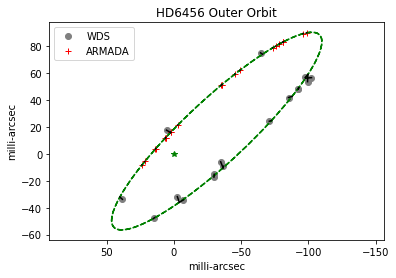

Only plotting best


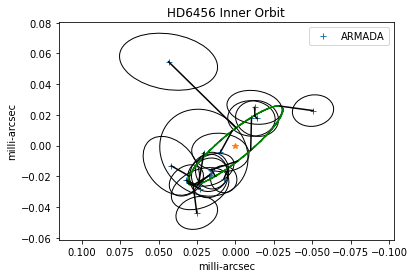

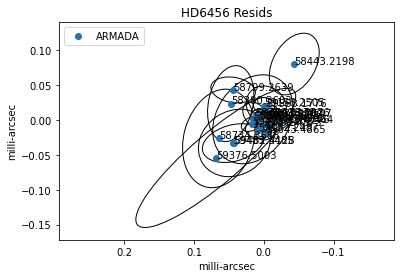

----------
Mean residual = 18.18 micro-as
----------


In [39]:
fig,ax=plt.subplots()

###################################################
## set up zoomed insets
#axins=zoomed_inset_axes(ax,5,bbox_to_anchor=(170,120))
#axins.plot(ra,dec,'-',color='g')
#if len(vlti_idx)>0:
#    axins.plot(xpos[vlti_idx],ypos[vlti_idx],'*',color='red')
#    axins.plot(xpos[vlti_mask],ypos[vlti_mask],'+',color='blue')
#else:
#    axins.plot(xpos,ypos,'o',color='red')
#axins.plot(0,0,'*',color='g')
#axins.set_ylim(-130,-110)
#axins.set_xlim(55,85)
##axins.plot([-115.5,-115.55],[56,56],'-')
##axins.annotate('50 $\mu$-as',xy=(-115.5,56.1),size=8)
##axins.set_xticks([])
##axins.set_yticks([])
#axins.tick_params(axis = 'both', which = 'major', labelsize = 8)
#mark_inset(ax,axins,loc1=3,loc2=4,fc="none",lw=0)
#axins.invert_xaxis()
###################################################

ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS',color='grey')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx],ypos[vlti_idx],'*', label='ARMADA-VLTI',color='red')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'+', label='ARMADA-CHARA',color='blue')
else:
    ax.plot(xpos,ypos,'+', label='ARMADA',color='red')
ax.plot(0,0,'*',color='g')
ax.plot(ra, dec, '--',color='g')

#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
ax.legend()
plt.savefig('%s/HD%s_%s_outer_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

tmodel = np.linspace(t[0],t[0]+3*P2_best,1000)
ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)

## plot inner wobble
#idx = np.where(error_maj/scale<1)
ra_inner = ra - ra2
dec_inner = dec - dec2
rapoints_inner = rapoints - rapoints2
decpoints_inner = decpoints - decpoints2

xpos_inner = xpos_all - rapoints2
ypos_inner = ypos_all - decpoints2

print('Only plotting best')
elim = 0.04
idx = np.where(error_maj/scale<elim)

fig,ax=plt.subplots()
if len(vlti_idx)>0:
    ax.plot(xpos_inner[:len(xpos)][vlti_idx],ypos_inner[:len(xpos)][vlti_idx],'+', label='ARMADA-VLTI')
    ax.plot(xpos_inner[:len(xpos)][vlti_mask],ypos_inner[:len(xpos)][vlti_mask],'+', label='ARMADA-CHARA')
else:
    ax.plot(xpos_inner[:len(xpos)][idx],ypos_inner[:len(xpos)][idx],'+', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='g')

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle,d in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg,t):
    if w<elim:
        ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                            angle=90-angle, facecolor='none', edgecolor='black')
        ax.add_patch(ellipse)
    #ax.annotate(d,xy=(ras,decs))

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)][idx]):
    x=[xpos_inner[:len(xpos)][idx][i],rapoints_inner[:len(xpos)][idx][i]]
    y=[ypos_inner[:len(xpos)][idx][i],decpoints_inner[:len(xpos)][idx][i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_inner_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## plot resids for ARMADA
fig,ax=plt.subplots()
xresid = xpos - rapoints[:len(xpos)]
yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle,d in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg,t):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)
    ax.annotate(d,xy=(ras,decs))

if len(vlti_idx)>0:
    ax.plot(xresid[vlti_idx],yresid[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xresid[vlti_mask],yresid[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xresid,yresid,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_resid_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

## Save txt file with best orbit
f = open("%s/%s_%s_orbit_triple.txt"%(directory,target_hd,note),"w+")
f.write("# P(d) a(mas) e i(deg) w(deg) W(deg) T(mjd) P2 a2 e2 i2 w2 W2 T2 mirc_scale K gamma mean_resid(mu-as)\r\n")
f.write("%s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s"%(P_best,
                                    a_best,e_best,
                                   inc_best,w_best,
                                   bigw_best,T_best,
                                   P2_best,a2_best,e2_best,
                                   inc2_best,w2_best,
                                   bigw2_best,T2_best,
                                  mirc_scale_best,K_best,
                                  gamma_best,resids_median))
f.close()

In [40]:
elim

0.04

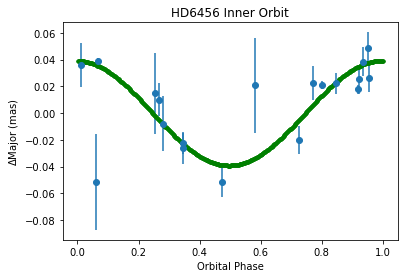

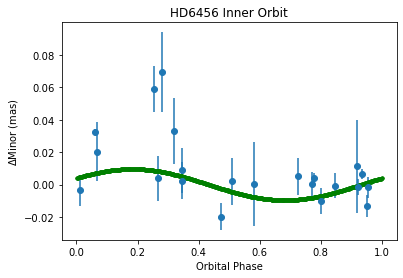

In [41]:
########################
## Plot RA vs DEC
########################

foldtime= foldAt(t,P2_best,T0=T2_best)
tt= foldAt(tmodel,P2_best,T0=T2_best)

xerr = error_maj/scale*np.sin(error_deg*np.pi/180)
yerr = error_min/scale*np.cos(error_deg*np.pi/180)

major_vector_x=np.sin(bigw_best*np.pi/180)
major_vector_y=np.cos(bigw_best*np.pi/180)
minor_vector_x=-major_vector_y
minor_vector_y=major_vector_x

data_major=(xpos_inner[:len(xpos)]*major_vector_x+ypos_inner[:len(xpos)]*major_vector_y)
data_minor=(xpos_inner[:len(xpos)]*minor_vector_x+ypos_inner[:len(xpos)]*minor_vector_y)
err_proj_major=abs(xerr*major_vector_x+yerr*major_vector_y)
err_proj_minor=abs(xerr*minor_vector_x+yerr*minor_vector_y)

idx_x = np.where(err_proj_major>elim)
idx_y = np.where(err_proj_minor>elim)
data_major[idx_x]=np.nan
data_minor[idx_y]=np.nan

model_major=(ra_inner*major_vector_x+dec_inner*major_vector_y)
model_minor=(ra_inner*minor_vector_x+dec_inner*minor_vector_y)

fig,ax=plt.subplots()
if len(vlti_idx)>0: 
    ax.errorbar(foldtime[:len(xpos)][vlti_idx],data_major[vlti_idx],err_proj_major[vlti_idx],fmt='o',label='ARMADA-VLTI')
    ax.errorbar(foldtime[:len(xpos)][vlti_mask],data_major[vlti_mask],err_proj_major[vlti_mask],fmt='o',label='ARMADA-CHARA')
else:
    ax.errorbar(foldtime,data_major,err_proj_major,fmt='o',label='ARMADA')

ax.plot(tt,model_major,'.',color='g',markersize=6)

ax.set_xlabel('Orbital Phase')
ax.set_ylabel('$\Delta$Major (mas)')
ax.set_title('HD%s Inner Orbit'%target_hd)
#plt.legend()
plt.savefig('%s/HD%s_%s_inner_triple_major.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

#####################
#####################

fig,ax=plt.subplots()
if len(vlti_idx)>0: 
    ax.errorbar(foldtime[:len(xpos)][vlti_idx],data_minor[:len(xpos)][vlti_idx],err_proj_minor[vlti_idx],fmt='o',label='ARMADA-VLTI')
    ax.errorbar(foldtime[:len(xpos)][vlti_mask],data_minor[:len(xpos)][vlti_mask],err_proj_minor[vlti_mask],fmt='o',label='ARMADA-CHARA')
else:
    ax.errorbar(foldtime[:len(xpos)],data_minor[:len(xpos)],err_proj_minor,fmt='o',label='ARMADA')

ax.plot(tt,model_minor,'.',color='g',markersize=6)

ax.set_xlabel('Orbital Phase')
ax.set_ylabel('$\Delta$Minor (mas)')
ax.set_title('HD%s Inner Orbit'%target_hd)
#plt.legend()
plt.savefig('%s/HD%s_%s_inner_triple_minor.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

In [ ]:
#Plot RV results:
w2_rv = w2_best*np.pi/180+np.pi
foldtime= foldAt(t_rv,P2_best,T0=T2_best)
tt=np.linspace(T2_best,T2_best+P2_best,100)
MM=[]
for i in tt:
    mm_anom=2*np.pi/P2_best*(i-T2_best)
    MM.append(mm_anom)
MM=np.asarray(MM)
EE=[]
for j in MM:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e2_best)
    EE.append(ee_anom)
EE=np.asarray(EE)
MM2=[]
for i in t_rv:
    mm_anom=2*np.pi/P2_best*(i-T2_best)
    MM2.append(mm_anom)
MM2=np.asarray(MM2)
EE2=[]

for j in MM2:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e2_best)
    EE2.append(ee_anom)
EE2=np.asarray(EE2)

f=2*np.arctan(np.sqrt((1+e2_best)/(1-e2_best))*np.tan(EE/2))
y1=K_best*(np.cos(w2_rv+f)+e2_best*np.cos(w2_rv))+gamma_best
tt_fold=foldAt(tt,P2_best,T0=T2_best)

fpoints=2*np.arctan(np.sqrt((1+e2_best)/(1-e2_best))*np.tan(EE2/2))
y1points=K_best*(np.cos(w2_rv+fpoints)+e2_best*np.cos(w2_rv))+gamma_best

plt.errorbar(foldtime,rv,yerr=err_rv,fmt='o')
plt.plot(tt_fold,y1,'.')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve')
plt.savefig('%s/HD%s_%s_orbit_rv.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

plt.errorbar(foldtime,rv-y1points,yerr=err_rv,fmt='o')
plt.plot([0,1],[0,0],'--')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve')
plt.savefig('%s/HD%s_%s_orbit_resids_rv.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

In [ ]:
#err_rv = err_rv *2
print(err_rv)

In [64]:
## print info for table
idx = t.argsort()
instrument = 'MIRC-X'

for j,k,l,m,n,o in zip(t[idx],p[idx],theta[idx]*180/np.pi,error_maj[idx],error_min[idx],error_deg[idx]):
    print('& %s & %s & %s & %s & %s & %s & %s \\\\'%(j,np.around(k,3),np.around(l,3),np.around(m,5),np.around(n,5),np.around(o,4),instrument))

& 58027.1438 & 89.508 & 14.716 & 0.14875 & 0.11717 & 294.8789 & MIRC-X \\
& 58637.3634 & 86.872 & 347.418 & 0.0658 & 0.04665 & 301.0557 & MIRC-X \\
& 58695.2326 & 85.997 & 344.693 & 0.0456 & 0.035 & 334.2466 & MIRC-X \\
& 58701.2369 & 85.88 & 344.405 & 0.02191 & 0.01632 & 322.125 & MIRC-X \\
& 58703.2283 & 85.809 & 344.315 & 0.03307 & 0.02014 & 326.3754 & MIRC-X \\
& 58734.1613 & 85.393 & 342.802 & 0.16765 & 0.12438 & 320.5358 & MIRC-X \\
& 58770.1801 & 84.7 & 341.086 & 0.04538 & 0.02272 & 52.0262 & MIRC-X \\
& 59004.4051 & 79.979 & 328.94 & 0.02863 & 0.02123 & 321.2851 & MIRC-X \\
& 59043.2911 & 78.993 & 326.779 & 0.02583 & 0.01594 & 319.8161 & MIRC-X \\
& 59044.3266 & 79.017 & 326.731 & 0.01616 & 0.01383 & 38.9684 & MIRC-X \\
& 59076.2316 & 78.206 & 324.91 & 0.03251 & 0.02157 & 356.3595 & MIRC-X \\
& 59155.1375 & 76.071 & 320.188 & 0.05352 & 0.01874 & 43.4103 & MIRC-X \\
& 59158.1242 & 75.985 & 320.034 & 0.03422 & 0.0156 & 52.8562 & MIRC-X \\
& 59305.548 & 71.301 & 310.438 & 0.0589 &

In [ ]:
## Mass / Orbit Information

a_err = ufloat(result.params['a'].value,result.params['a'].stderr)
P_err = ufloat(result.params['P'].value,result.params['P'].stderr)
T_err = ufloat(result.params['T'].value,result.params['T'].stderr)
e_err = ufloat(result.params['e'].value,result.params['e'].stderr)
w_err = ufloat(result.params['w'].value,result.params['w'].stderr)
bigw_err = ufloat(result.params['bigw'].value,result.params['bigw'].stderr)
inc_err = ufloat(result.params['inc'].value,result.params['inc'].stderr)

a2_err = ufloat(result.params['a2'].value,result.params['a2'].stderr)
P2_err = ufloat(result.params['P2'].value,result.params['P2'].stderr)
T2_err = ufloat(result.params['T2'].value,result.params['T2'].stderr)
e2_err = ufloat(result.params['e2'].value,result.params['e2'].stderr)
w2_err = ufloat(result.params['w2'].value,result.params['w2'].stderr)
bigw2_err = ufloat(result.params['bigw2'].value,result.params['bigw2'].stderr)
inc2_err = ufloat(result.params['inc2'].value,result.params['inc2'].stderr)

if include_rv=='y':
    K_err = ufloat(result.params['K'].value,result.params['K'].stderr)
    gamma_err = ufloat(result.params['gamma'].value,result.params['gamma'].stderr)

## distance from HIP/GAIA
##hd6456
plx_hip = ufloat(0.01186,0.00068)
plx_gaia = ufloat(0.0107087,0.0006038)

##hd82446
#plx_hip = ufloat(0.0063,0.00072)
#plx_gaia = ufloat(0.0055119,0.0002766)

## Radial Velocity parameters included
if include_rv=='y':
    semi1 = P2_err*24*60*60*abs(K_err)*(1-e2_err**2)**(1/2)/(2*np.pi)/1.496e8/umath.sin(inc2_err*np.pi/180)
    #print(semi1)

    #mratio_err = K_ab_err / K_aa_err
    #d_rv = semi1 / ((a2_err/(1+mratio_err)*mratio)/1000) ## WHICH SEMI IS IT?!?!?
    d_rv = semi1 / (a2_err/1000)
    #d_rv = semi1 / ((a2_err - a1_err)/1000)

print('Distance from HIP = ')
print(1/plx_hip)
print('Distance from GAIA = ')
print(1/plx_gaia)
if include_rv=='y':
    print('Distance from RV = ')
    print(d_rv)

d_err = 1/plx_gaia
#d_err = d_rv


In [ ]:
print('%s & %s & %s & %s & %s & %s & %s & %s'%(target_hd,P_err.nominal_value,a_err.nominal_value,
                                               e_err.nominal_value,inc_err.nominal_value,
                                               w_err.nominal_value,bigw_err.nominal_value,
                                               T_err.nominal_value))
print('-- & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s'%(P_err.std_dev,a_err.std_dev,
                                                                                  e_err.std_dev,inc_err.std_dev,w_err.std_dev,
                                                                                  bigw_err.std_dev,T_err.std_dev,))
print('--'*10)

if include_rv=='y':
    print('%s & %s & %s & %s & %s & %s & %s & %s & %s & %s'%(target_hd,P2_err.nominal_value,a2_err.nominal_value,
                                                             e2_err.nominal_value,inc2_err.nominal_value,
                                                             w2_err.nominal_value,bigw2_err.nominal_value,
                                                             T2_err.nominal_value,K_err.nominal_value,
                                                             gamma_err.nominal_value))
    print('-- & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s'%(P2_err.std_dev,
                                                                                                          a2_err.std_dev,e2_err.std_dev,
                                                                                                          inc2_err.std_dev,w2_err.std_dev,
                                                                                                          bigw2_err.std_dev,T2_err.std_dev,
                                                                                                          K_err.std_dev,gamma_err.std_dev,))
else:
    print('%s & %s & %s & %s & %s & %s & %s & %s & -- & --'%(target_hd,P2_err.nominal_value,a2_err.nominal_value,
                                                             e2_err.nominal_value,inc2_err.nominal_value,
                                                             w2_err.nominal_value,bigw2_err.nominal_value,
                                                             T2_err.nominal_value))
    print('-- & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & $\pm$%s & & '%(P2_err.std_dev,
                                                                                                          a2_err.std_dev,e2_err.std_dev,
                                                                                                          inc2_err.std_dev,w2_err.std_dev,
                                                                                                          bigw2_err.std_dev,T2_err.std_dev))

In [ ]:
d_err = 1/plx_gaia
#d_err = d_rv

print('-'*10)
print('Masses from distance')
print('-'*10)

sum1 = (a_err*d_err/1000)**3 / (P_err/365.25)**2
print('M1+M2+M3 = %s Msun'%sum1)

## need to assume a mass
m3 = 3.6

print('-'*10)
minner_tot = sum1 - m3
print('M1+M2=',minner_tot)

a_inner_err = (minner_tot * (P2_err/365.25)**2)**(1/3) / d_err
#print(a_inner_err)
semi2 = a_inner_err*1000 - a2_err
mratio_inner = semi2/a2_err
print('Mratio inner = ', mratio_inner)

print('-'*10)
m1 = minner_tot / (1+1/mratio_inner)
m2 = minner_tot - m1
m3 = sum1 - m1 - m2
print('M1=', m1)
print('M2=', m2)
print('M3=', m3)

In [ ]:
a2_err

In [ ]:
#### Another way to do masses
d_err = 1/plx_gaia
M1 = 2.21
M2 = 1.73
#M1 = 3.6
#M2 = 3.3

semi1 = (M1*(P2_err/365.25)**2)**(1/3) / d_err * 1000
mass_inner1 = M1*(a2_err) / (semi1-a2_err)

semi2 = (M2*(P2_err/365.25)**2)**(1/3) / d_err * 1000
mass_inner2 = M2*(a2_err) / (semi2-a2_err)

print('Mass 1 (solar) = ', mass_inner1)
print('Mass 2 (solar) = ', mass_inner2)

print('Mass 1 (Jup) = ', mass_inner1 * 1047.57)
print('Mass 2 (Jup) = ', mass_inner2 * 1047.57)

In [ ]:
#ainner = ((P2_err/365.25)**2 * (minner_tot))**(1/3)
#aouter = ((P_err/365.25)**2 * (sum1))**(1/3)
if include_rv=='y':
    ainner = a_inner_err/1000*d_rv
    aouter = a_err/1000*d_rv
    print('a_inner = %s au'%ainner)
    print('a_outer = %s au'%aouter)

    print(' ')

mutual_inc1 = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc2_err*np.pi/180)+
                        umath.sin(inc_err*np.pi/180)*umath.sin(inc2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err)*np.pi/180))
mutual_inc2 = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc2_err*np.pi/180)+
                        umath.sin(inc_err*np.pi/180)*umath.sin(inc2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err+180)*np.pi/180))

print("Mutual Inclination = ", mutual_inc1*180/np.pi, 'OR', mutual_inc2*180/np.pi)

In [ ]:
scale1_err = ufloat(1.00495,0.00017)
scale2_err = ufloat(1.00501,0.00021)
scale3_err = ufloat(1.0061,0.0005)

mean_scale = (scale1_err+scale2_err+scale3_err)/3

print(mean_scale)

## MCMC

In [46]:
## Save a fit for errors
params = Parameters()
params.add('w',   value = w_best, min=0, max=360)
params.add('bigw', value = bigw_best, min=0, max=180)
params.add('inc', value = inc_best, min=0, max=180)
params.add('e', value = e_best, min=0, max=0.99)
params.add('a', value = a_best, min=0)
params.add('P', value = P_best, min=0)
params.add('T', value = T_best, min=0)

if circular!='y':
    params.add('w2',   value= w2_best, min=0, max=360)
    params.add('e2', value= e2_best, min=0,max=0.99)
else:
    params.add('w2',   value= 0, vary=False)
    params.add('e2', value= 0, vary=False)
        
params.add('bigw2', value= bigw2_best, min=0, max=360)
params.add('inc2', value= inc2_best, min=0, max=180)
params.add('a2', value= a2_best, min=0)
params.add('P2', value= P2_best, min=0)
params.add('T2', value= T2_best, min=T2_best-1,max = T2_best+1)

if include_rv=='y':
    params.add('K', value= K_best)
    #params.add('K_outer', value= K_outer_best)
    params.add('gamma', value= gamma_best)

if len(vlti_idx)>0:
    params.add('mirc_scale', value=mirc_scale_best)
else:
    params.add('mirc_scale',value=1,vary=False)

#params.add('pscale', value=1)

#do fit, minimizer uses LM for least square fitting of model to data
if include_rv=='y':
    if len(vlti_idx)>0:
        minner = Minimizer(triple_model_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                            error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                            error_pa_all[vlti_mask_all],
                                                            xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                            error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                            error_pa_all[vlti_idx],rv,t_rv,err_rv),
                            nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(triple_model_combined, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                            error_maj_all,error_min_all,
                                                            error_pa_all,rv,t_rv,err_rv),
                            nan_policy='omit')
        result = minner.minimize()
    include_rv = 'y'
else:
    if len(vlti_idx)>0:
        minner = Minimizer(triple_model_vlti, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                            error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                            error_pa_all[vlti_mask_all],
                                                            xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                            error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                            error_pa_all[vlti_idx]),
                            nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(triple_model, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                            error_maj_all,error_min_all,
                                                            error_pa_all),
                            nan_policy='omit')
        result = minner.minimize()

report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14
    # data points      = 80
    # variables        = 12
    chi-square         = 59.9949941
    reduced chi-square = 0.88227932
    Akaike info crit   = 0.97875936
    Bayesian info crit = 29.5630790
[[Variables]]
    w:           305.133986 +/- 0.14054012 (0.05%) (init = 305.1339)
    bigw:        135.043056 +/- 0.00710755 (0.01%) (init = 135.0431)
    inc:         77.6022252 +/- 0.01936161 (0.02%) (init = 77.60223)
    e:           0.51952077 +/- 7.3736e-04 (0.14%) (init = 0.5195207)
    a:           115.571780 +/- 0.10725808 (0.09%) (init = 115.5718)
    P:           5308.77627 +/- 6.36672081 (0.12%) (init = 5308.777)
    T:           54290.3273 +/- 6.63615204 (0.01%) (init = 54290.33)
    w2:          0 (fixed)
    e2:          0 (fixed)
    bigw2:       129.312463 +/- 7.69088213 (5.95%) (init = 129.2986)
    inc2:        102.886731 +/- 7.49899286 (7.29%) (init = 102.8955)
    a2:          0.03935213 +/

In [47]:
emcee_params = result.params.copy()
nwalkers = 2*len(emcee_params)
steps = 50000
burn = 10000
thin = 100

In [48]:
if include_rv=='y':
    if len(vlti_idx)>0:
        minner = Minimizer(triple_model_vlti_combined, emcee_params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                            error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                            error_pa_all[vlti_mask_all],
                                                            xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                            error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                            error_pa_all[vlti_idx],rv,t_rv,err_rv),
                            nan_policy='omit')
        result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)
    else:
        minner = Minimizer(triple_model_combined, emcee_params, fcn_args=(xpos_all,ypos_all,t_all,
                                                            error_maj_all,error_min_all,
                                                            error_pa_all,rv,t_rv,err_rv),
                            nan_policy='omit')
        result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)
else:
    if len(vlti_idx)>0:
        minner = Minimizer(triple_model_vlti, emcee_params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                            error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                            error_pa_all[vlti_mask_all],
                                                            xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                            error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                            error_pa_all[vlti_idx]),
                            nan_policy='omit')
        result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)
    else:
        minner = Minimizer(triple_model, emcee_params, fcn_args=(xpos_all,ypos_all,t_all,
                                                            error_maj_all,error_min_all,
                                                            error_pa_all),
                            nan_policy='omit')
        result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)

  0%|          | 0/50000 [00:00<?, ?it/s]/usr/local/anaconda/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [48:40<00:00, 17.12it/s] 
/usr/local/anaconda/lib/python3.8/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


In [49]:
report_fit(result)

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 1500000
    # data points      = 80
    # variables        = 12
    chi-square         = 121.409926
    reduced chi-square = 1.78544009
    Akaike info crit   = 57.3716803
    Bayesian info crit = 85.9559999
[[Variables]]
    w:           305.115593 +/- 0.12905514 (0.04%) (init = 305.134)
    bigw:        135.046303 +/- 0.00830841 (0.01%) (init = 135.0431)
    inc:         77.5998803 +/- 0.01738848 (0.02%) (init = 77.60223)
    e:           0.51949925 +/- 6.6839e-04 (0.13%) (init = 0.5195208)
    a:           115.571155 +/- 0.09767922 (0.08%) (init = 115.5718)
    P:           5309.17800 +/- 5.71285038 (0.11%) (init = 5308.776)
    T:           54290.0211 +/- 6.52485273 (0.01%) (init = 54290.33)
    w2:          0 (fixed)
    e2:          0 (fixed)
    bigw2:       129.845340 +/- 8.56578737 (6.60%) (init = 129.3125)
    inc2:        102.881967 +/- 8.58754000 (8.35%) (init = 102.8867)
    a2:          0.03714299 

In [50]:
chains = result.flatchain
print(chains.shape)

(12000, 12)


In [51]:
## save chains
np.save("%s/%s_%s_chains"%(directory,target_hd,note),chains)

In [52]:
## load chains
chains = np.load("%s/%s_%s_chains.npy"%(directory,target_hd,note))

In [53]:
chains.shape

(12000, 12)

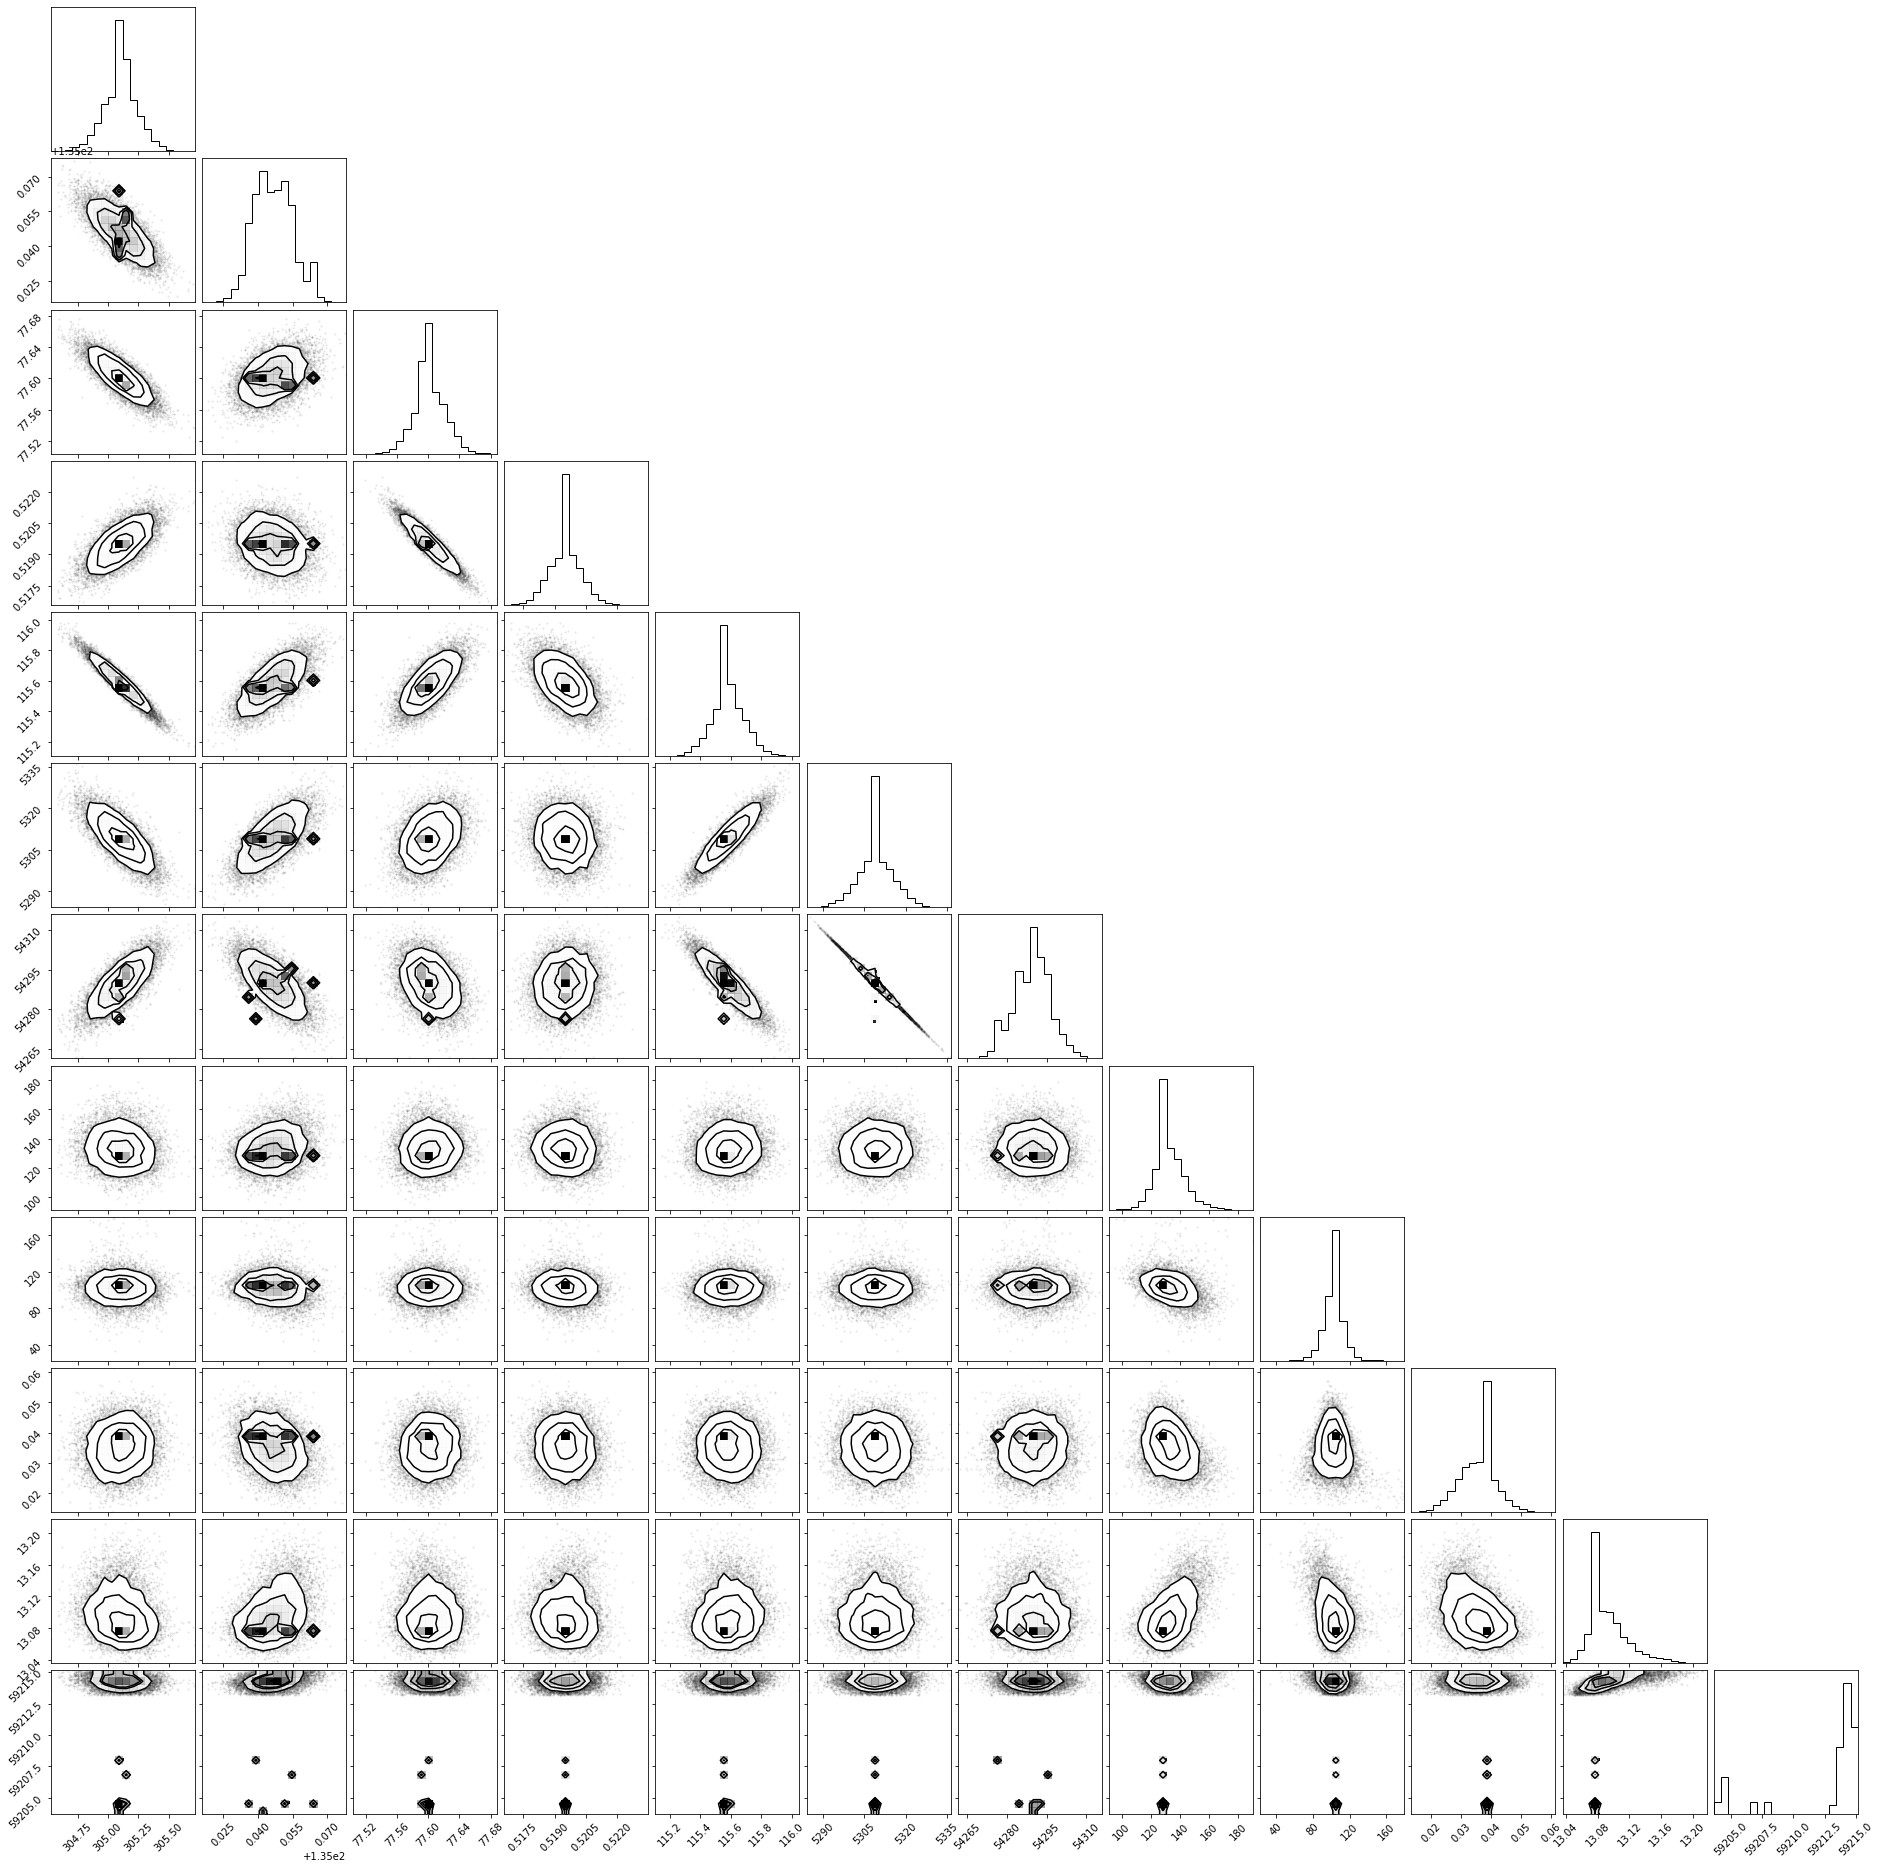

In [54]:
emcee_plot = corner.corner(chains)#, labels=result.var_names,
                           #truths=list(result.params.valuesdict().values()))

IndexError: index 12 is out of bounds for axis 1 with size 12

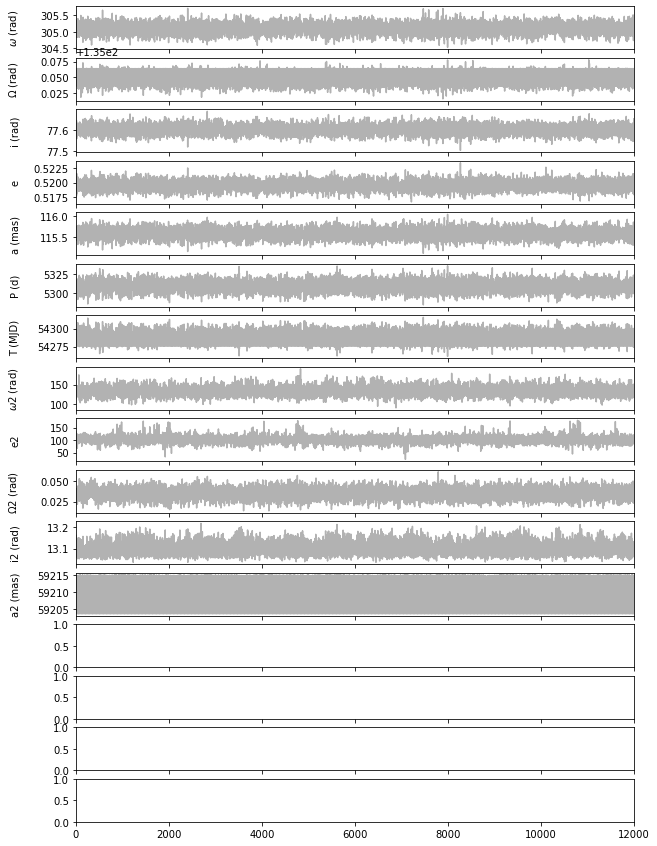

In [55]:
## look at walkers 
fig, axes = plt.subplots(16, figsize=(10, 15), sharex=True)

labels=["$\omega$ (rad)","$\Omega$ (rad)","i (rad)","e","a (mas)","P (d)","T (MJD)",
       "$\omega$2 (rad)","e2","$\Omega$2 (rad)","i2 (rad)","a2 (mas)","P2 (d)","T2 (MJD)",
       "K (km/s)", "gamma (km/s)", "scale_factor"]

for i in range(16):
    ax = axes[i]
    ax.plot(chains[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(chains))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
    
plt.savefig('%s/HD%s_chains.pdf'%(directory,target_hd))
plt.show()

In [56]:
w_chain = chains[:,0]
bigw_chain = chains[:,1]
inc_chain = chains[:,2]
e_chain = chains[:,3]
a_chain = chains[:,4]
P_chain = chains[:,5]
T_chain = chains[:,6]

circular = 'y'
if circular=='y':
    e2_chain = np.zeros(len(chains[:,7]))
    w2_chain = np.zeros(len(chains[:,7]))
    bigw2_chain = chains[:,7]
    inc2_chain = chains[:,8]
    a2_chain = chains[:,9]
    P2_chain = chains[:,10]
    T2_chain = chains[:,11]
else:
    w2_chain = chains[:,7]
    e2_chain = chains[:,8]
    bigw2_chain = chains[:,9]
    inc2_chain = chains[:,10]
    a2_chain = chains[:,11]
    P2_chain = chains[:,12]
    T2_chain = chains[:,13]

In [57]:
idx = np.random.randint(0,len(chains),size=100)

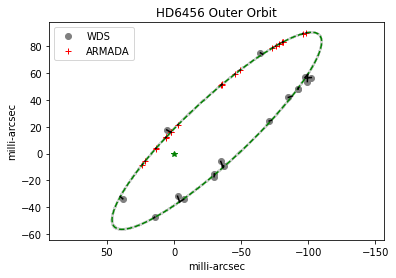

In [58]:
fig,ax=plt.subplots()

####################################################
### set up zoomed insets
#axins=zoomed_inset_axes(ax,5,bbox_to_anchor=(170,120))
#axins.plot(ra,dec,'-',color='g')
#if len(vlti_idx)>0:
#    axins.plot(xpos[vlti_idx],ypos[vlti_idx],'*',color='red')
#    axins.plot(xpos[vlti_mask],ypos[vlti_mask],'+',color='blue')
#else:
#    axins.plot(xpos,ypos,'o',color='red')
#axins.plot(0,0,'*',color='g')
#axins.set_xlim(55,85)
#axins.set_ylim(-130,-110)
##axins.plot([-115.5,-115.55],[56,56],'-')
##axins.annotate('50 $\mu$-as',xy=(-115.5,56.1),size=8)
##axins.set_xticks([])
##axins.set_yticks([])
#axins.tick_params(axis = 'both', which = 'major', labelsize = 8)
#mark_inset(ax,axins,loc1=3,loc2=4,fc="none",lw=0)
#axins.invert_xaxis()
###################################################

for orbit in idx:

    tmod = np.linspace(min(t_all),min(t_all)+2*P_best,1000)
    ra,dec,rapoints,decpoints = triple_orbit_model(a_chain[orbit],e_chain[orbit],inc_chain[orbit],
                                                w_chain[orbit],bigw_chain[orbit],P_chain[orbit],
                                                T_chain[orbit],a2_chain[orbit],e2_chain[orbit],
                                                inc2_chain[orbit],w2_chain[orbit],bigw2_chain[orbit],
                                                P2_chain[orbit],T2_chain[orbit],t_all,tmod)
    ax.plot(ra, dec, '--',color='lightgrey')

tmod = np.linspace(min(t_all),min(t_all)+P_best,1000)
ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,t_all,tmod)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmod)

ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS',color='grey')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx],ypos[vlti_idx],'*', label='ARMADA-VLTI',color='red')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'+', label='ARMADA-CHARA',color='blue')
else:
    ax.plot(xpos,ypos,'+', label='ARMADA',color='red')
ax.plot(0,0,'*',color='g')
ax.plot(ra, dec, '--',color='g')

#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1

ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
ax.legend()
plt.savefig('%s/HD%s_%s_outer_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

Only plotting best


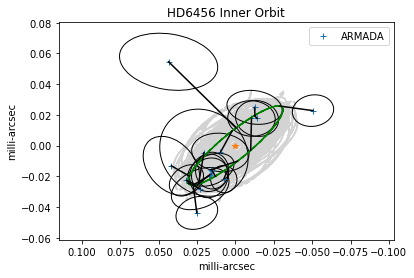

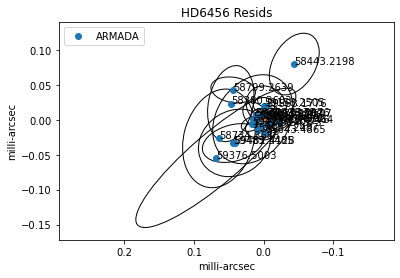

----------
Mean residual = 18.19 micro-as
----------


In [60]:
## plot inner wobble
scale=1

fig,ax=plt.subplots()

idx = np.random.randint(0,len(chains),size=100)
for orbit in idx:

    tmodel = np.linspace(t[0],t[0]+3*P2_best,1000)
    
    ## random inner and outer
    ra,dec,rapoints,decpoints = triple_orbit_model(a_chain[orbit],e_chain[orbit],inc_chain[orbit],
                                                w_chain[orbit],bigw_chain[orbit],P_chain[orbit],
                                                T_chain[orbit],a2_chain[orbit],e2_chain[orbit],
                                                inc2_chain[orbit],w2_chain[orbit],bigw2_chain[orbit],
                                                P2_chain[orbit],T2_chain[orbit],t_all,tmodel)
    ra2,dec2,rapoints2,decpoints2 = orbit_model(a_chain[orbit],e_chain[orbit],inc_chain[orbit],
                                        w_chain[orbit],bigw_chain[orbit],P_chain[orbit],
                                        T_chain[orbit],t_all,tmodel)
    
    ## random inner
    #ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
    #                                            w_best,bigw_best,P_best,
    #                                            T_best,a2_chain[orbit],e2_chain[orbit],
    #                                            inc2_chain[orbit],w2_chain[orbit],bigw2_chain[orbit],
    #                                            P2_chain[orbit],T2_chain[orbit],t_all,tmodel)
    #ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
    #                                    w_best,bigw_best,P_best,
    #                                    T_best,t_all,tmodel)
    
    ra_inner = ra - ra2
    dec_inner = dec - dec2
    ax.plot(ra_inner, dec_inner, '--',color='lightgrey',zorder=0)

tmodel = np.linspace(t[0],t[0]+3*P2_best,1000)
ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)

ra_inner = ra - ra2
dec_inner = dec - dec2
rapoints_inner = rapoints - rapoints2
decpoints_inner = decpoints - decpoints2

xpos_inner = xpos_all - rapoints2
ypos_inner = ypos_all - decpoints2

print('Only plotting best')
elim = 0.04
idx2 = np.where(error_maj/scale<elim)

if len(vlti_idx)>0:
    ax.plot(xpos_inner[:len(xpos)][vlti_idx],ypos_inner[:len(xpos)][vlti_idx],'+', label='ARMADA-VLTI')
    ax.plot(xpos_inner[:len(xpos)][vlti_mask],ypos_inner[:len(xpos)][vlti_mask],'+', label='ARMADA-CHARA')
else:
    ax.plot(xpos_inner[:len(xpos)][idx2],ypos_inner[:len(xpos)][idx2],'+', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='g')

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle,d in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg,t):
    if w<elim:
        ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                            angle=90-angle, facecolor='none', edgecolor='black')
        ax.add_patch(ellipse)
    #ax.annotate(d,xy=(ras,decs))

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)][idx2]):
    x=[xpos_inner[:len(xpos)][idx2][i],rapoints_inner[:len(xpos)][idx2][i]]
    y=[ypos_inner[:len(xpos)][idx2][i],decpoints_inner[:len(xpos)][idx2][i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_inner_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## plot resids for ARMADA
fig,ax=plt.subplots()
xresid = xpos - rapoints[:len(xpos)]
yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle,d in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg,t):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)
    ax.annotate(d,xy=(ras,decs))

if len(vlti_idx)>0:
    ax.plot(xresid[vlti_idx],yresid[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xresid[vlti_mask],yresid[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xresid,yresid,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_resid_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

## Save txt file with best orbit
f = open("%s/%s_%s_orbit_triple.txt"%(directory,target_hd,note),"w+")
f.write("# P(d) a(mas) e i(deg) w(deg) W(deg) T(mjd) P2 a2 e2 i2 w2 W2 T2 mirc_scale K gamma mean_resid(mu-as)\r\n")
f.write("%s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s"%(P_best,
                                    a_best,e_best,
                                   inc_best,w_best,
                                   bigw_best,T_best,
                                   P2_best,a2_best,e2_best,
                                   inc2_best,w2_best,
                                   bigw2_best,T2_best,
                                  mirc_scale_best,K_best,
                                  gamma_best,resids_median))
f.close()

In [ ]:
for tt,xx,yy,eemaj,eemin,eepa in zip(t,xresid,yresid,error_maj/scale,error_min/scale,error_deg):
    print(tt,xx,yy,eemaj,eemin,eepa)

In [ ]:
np.std(a2_chain)